<a href="https://colab.research.google.com/github/donalhill/portfolio-projects/blob/main/cell_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Cell segmentation using Keras and a U-Net model architecture

In segmentation tasks, the goal is to extract a specific object or group of objects from an image. As opposed image classification where an entire image is labelled (e.g. this image is of a dog), or bounding box object detection where a box is drawn around an object within an image (e.g. here is where the dog is within this image), segmentation assigns each pixel in an image to a certain class (e.g. all of these pixels belong to a dog). In this notebook, the objects we wish to segment are biological cells appearing against a background.

In the image data we will work with, the task of segmenting cells is a binary classification problem; either a pixel belongs to a cell, or to the background. We are given a microscope image, and we need to extract the cells from the image. To do this we need to classify each pixel in the image as either being part of a cell or not. The target (ground truth) values are given to us as a binary mask, where each pixel is labelled as belonging to a cell or not. We will use the target mask when training our model.

Because we are dealing with a binary classification problem, we will use the `Sigmoid` activation function in the last layer of our neural network. We will also use the `binary_crossentropy` loss function.

When `Predict` is run, the model will output a 2D mask where each pixel in the predicted mask represents the probability that the given pixel is part of a cell. These probabilities can be converted into binary predictions, by thresholding either side of 0.5. 


## Check for GPU access

In [1]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-8d7704c8-7db0-14a9-45d1-c1e0968e54bc)


## Import required libraries

In [2]:
import pandas as pd
import numpy as np
import os

import matplotlib.pyplot as plt
%matplotlib inline

from skimage.io import imread, imshow
from skimage.transform import resize

## Change directory to my Google Drive Kaggle datasets folder

In [3]:
os.environ['KAGGLE_CONFIG_DIR'] = "/content/drive/MyDrive/Kaggle"
%cd /content/drive/MyDrive/Kaggle

/content/drive/MyDrive/Kaggle


We will be using the [Synthetic Cell Images and Masks](https://www.kaggle.com/datasets/vbookshelf/synthetic-cell-images-and-masks-bbbc005-v1) Kaggle dataset. Let's download it into our Google Drive Kaggle folder:

In [ ]:
#Download the required data for the cell image segmentation task
!kaggle datasets download -d vbookshelf/synthetic-cell-images-and-masks-bbbc005-v1

In [ ]:
#unzipping the zip files and deleting the zip files
!unzip \*.zip  && rm *.zip

## General specifications for image size we will pass to our model, how many colour channels we have, and how many images to hold out for testing

In [6]:
IMG_HEIGHT = 128
IMG_WIDTH = 128
IMG_CHANNELS = 1 #images are greyscale and 128 x 128 pixels

NUM_TEST_IMAGES = 10 #number of test images to hold out

##Put data info into a DataFrame

The dataframe will include the following info:

* IDs of all images
* Does the image have a mask?
* Number of cells on each image
* The amount of blurring that was aded to each image



In [7]:
# Get a list of files in each folder
img_list = os.listdir('bbbc005_v1_images/BBBC005_v1_images')
mask_list = os.listdir('bbbc005_v1_ground_truth/BBBC005_v1_ground_truth')

# create a dataframe
df_images = pd.DataFrame(img_list, columns=['image_id'])

# filter out the non image file called .htaccess
df_images = df_images[df_images['image_id'] != '.htaccess']

Add a column showing how many cells are in each image:

In [8]:
def get_num_cells(x):
    #Split on the _
    a = x.split('_')
    #Choose the third item, which is the number of cells 
    b = a[2] # e.g. C53 = 53 cells
    #Choose second item onwards to remove the C, and convert to int
    num_cells = int(b[1:])
    
    return num_cells

#Create a new column called 'num_cells'
df_images['num_cells'] = df_images['image_id'].apply(get_num_cells)

Add a column indicating if an image has a mask:

In [9]:
def check_for_mask(x):
    if x in mask_list:
        return 'yes'
    else:
        return 'no'
    
#Create a new column called 'has_mask'
df_images['has_mask'] = df_images['image_id'].apply(check_for_mask)

Add a column showing how much blur was added to each image:

In [10]:
def get_blur_amt(x):
    #Split on the _
    a = x.split('_')
    #Choose the third item
    b = a[3] # e.g. F1
    #Choose second item onwards and convert to int
    blur_amt = int(b[1:])
    
    return blur_amt

#Create a new column called 'blur_amt'
df_images['blur_amt'] = df_images['image_id'].apply(get_blur_amt)

We want to only use images which have a corresponding mask, so let's filter on the `has_mask` variable:

In [11]:
df_masks = df_images.query("has_mask == 'yes'")

#Create a new column called mask_id that is just a copy of image_id
df_masks['mask_id'] = df_masks['image_id']

df_masks.shape

(1200, 5)

## Create a test set

Here we will create a test set containing 10 images. Keras will automatically create a validation set during training, so we can compare the training and validation loss to check for any over-training.

In [12]:
#Create a test set
df_test = df_masks.sample(NUM_TEST_IMAGES, random_state=101)

# Reset the index, so we can use loc to access mask id's later
df_test = df_test.reset_index(drop=True)

#Create a list of test images
test_images_list = list(df_test['image_id'])

#Select only rows that are not part of the test set.
df_masks = df_masks[~df_masks['image_id'].isin(test_images_list)]

print(df_masks.shape)
print(df_test.shape)

(1190, 5)
(10, 5)


## Inspect one image and its mask

Here we want to check the image shapes, and whether they are greyscale or RGB. We need this information to process the images and masks into a format required for the model.




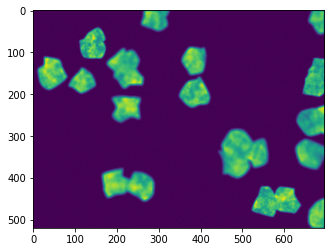

In [13]:
sample_image = 'SIMCEPImages_A06_C23_F1_s11_w2.TIF'
path_image = 'bbbc005_v1_images/BBBC005_v1_images/' + sample_image

#Read the image using skimage
image = imread(path_image)

plt.imshow(image);

In [14]:
print(f"Shape: {image.shape}")
print(f"Max pixel value: {image.max()}")
print(f"Min pixel value: {image.min()}")

Shape: (520, 696)
Max pixel value: 222
Min pixel value: 0


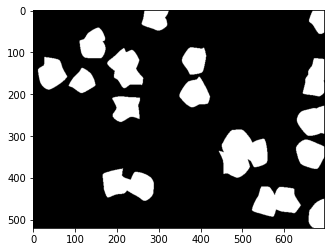

In [15]:
sample_mask = 'SIMCEPImages_A06_C23_F1_s11_w2.TIF'
path_mask = 'bbbc005_v1_ground_truth/BBBC005_v1_ground_truth/' + sample_mask

#Read the mask using skimage
mask = imread(path_mask)

plt.imshow(mask, cmap='gray');

In [16]:
print(f"Shape: {mask.shape}")
print(f"Max pixel value: {mask.max()}")
print(f"Min pixel value: {mask.min()}")

Shape: (520, 696)
Max pixel value: 255
Min pixel value: 0


The image and its associated mask have the same shape. We also see that the image is 2D and not 3D, such that there is no RGB axis. The image has pixel values in the range 0 to 255, whereas the mask values are either 0 or 255 (binary).

The model requires the following input format:

`(num_samples, num_rows, num_columns, num_channels)`

Therefore, we will need to use `np.expand_dims` to add a channel dimension to both the image and the mask. Also, the model expects input images and masks to have the same width and height. We will resize both images and the masks to `128 x 128`.

## Create `X_train`, `Y_train` and `X_test`

In [17]:
#Get lists of images and their masks.
image_id_list = list(df_masks['image_id'])
mask_id_list = list(df_masks['mask_id'])
test_id_list = list(df_test['image_id'])

#Create empty arrays
X_train = np.zeros((len(image_id_list), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)

Y_train = np.zeros((len(image_id_list), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)

X_test = np.zeros((NUM_TEST_IMAGES, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)

In [18]:
#X_train
for i, image_id in enumerate(image_id_list):
    
    path_image = 'bbbc005_v1_images/BBBC005_v1_images/' + image_id
    
    #Read the image using skimage
    image = imread(path_image)
    
    #Resize the image
    image = resize(image, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    
    #Use np.expand dims to add a channel axis so the shape becomes (IMG_HEIGHT, IMG_WIDTH, 1)
    image = np.expand_dims(image, axis=-1)
    
    #Insert the image into X_train
    X_train[i] = image
    
X_train.shape

(1190, 128, 128, 1)

In [19]:
#Y_train
for i, mask_id in enumerate(mask_id_list):
    
    path_mask = 'bbbc005_v1_ground_truth/BBBC005_v1_ground_truth/' + mask_id
    
    #Read the image using skimage
    mask = imread(path_mask)
    
    #Resize the image
    mask = resize(mask, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    
    #Use np.expand dims to add a channel axis so the shape becomes (IMG_HEIGHT, IMG_WIDTH, 1)
    mask = np.expand_dims(mask, axis=-1)
    
    #Insert the image into Y_train
    Y_train[i] = mask

Y_train.shape

(1190, 128, 128, 1)

In [20]:
#X_test
for i, image_id in enumerate(test_id_list):
    
    path_image = 'bbbc005_v1_images/BBBC005_v1_images/' + image_id
    
    #Read the image using skimage
    image = imread(path_image)
    
    #Resize the image
    image = resize(image, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    
    #Use np.expand dims to add a channel axis so the shape becomes (IMG_HEIGHT, IMG_WIDTH, 1)
    image = np.expand_dims(image, axis=-1)
    
    #Insert the image into X_test
    X_test[i] = image
    
X_test.shape

(10, 128, 128, 1)

## Model architecture

We will use the [U-Net](https://arxiv.org/abs/1505.04597) arhitecture. `U-Net` is a convolutional neural network (CNN) that was developed for biomedical image segmentation. It was designed to give good results when only a small number of training images are available, and was also designed to run quickly.

Note that the images are normalised inside the model using a lamda layer which divides each pixel value by 255.

## Imports for Keras and TensorFlow

In [21]:
from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K

import tensorflow as tf

## Define our U-Net model

In [22]:
#Source for model architecture: https://www.kaggle.com/keegil/keras-u-net-starter-lb-0-277

inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))

#Normalise each pixel to have a value between 0 and 1
s = Lambda(lambda x: x / 255) (inputs)

#Convolutional layers - the ENCODING satage of the U-Net

#First layer of convolutional filters
c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (s)
#10% dropout to guard against over-fitting
c1 = Dropout(0.1) (c1)
c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c1)
#Pooling to reduce the dimensionality
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p1)
c2 = Dropout(0.1) (c2)
c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p2)
c3 = Dropout(0.2) (c3)
c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p3)
c4 = Dropout(0.2) (c4)
c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p4)
c5 = Dropout(0.3) (c5)
c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c5)


#De-convolutional layers - the DECODING satage of the U-Net

#Reverse convolution operations, to take the high-level features learned by the above conv filters and use them to predict each pixel
u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
#Here with 'concatenate' we are adding something called a skip connection, which passes information from the earlier encoding stage (c4) into its corresponding decoding stage (u6)
#This stops information being lost as it passes through the various layers of the neutral network, and helps model convergence
#It guards against the vanisihing gradient problem, where the model starts to have trouble updating the weights for certain layers
u6 = concatenate([u6, c4])
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u6)
c6 = Dropout(0.2) (c6)
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c6)

u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u7)
c7 = Dropout(0.2) (c7)
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c7)

u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u8)
c8 = Dropout(0.1) (c8)
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c8)

u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u9)
c9 = Dropout(0.1) (c9)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c9)

#Output layer of the model, which has one neuron only since we're doing a binary classification task
outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9) #sigmoid activation is used for binary classification

model = Model(inputs=[inputs], outputs=[outputs])

#Could also look into dice loss and IoU loss functions, which are also popular in segmentation
model.compile(optimizer='adam', loss='binary_crossentropy') #adam optimiser with binary_crossentropy loss function for binary classification

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 lambda (Lambda)                (None, 128, 128, 1)  0           ['input_1[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 16  160         ['lambda[0][0]']                 
                                )                                                                 
                                                                                              

## Train the model

We'll let Keras automatically create a 10% validation set during training. No metric is specified here, but for segmentation problems custom metrics like IOU or dice coef are sometimes used.

In [23]:
filepath = "model.h5"

#Early stopping which will stop training if there is no improvement in the loss after X epochs
earlystopper = EarlyStopping(patience=5, verbose=1)

#Checkpointing allows us to retrieve the best performance epoch during training, in case our model starts to over-fit later in the epoch iterations
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min')

#Add the early stopping and model checkpointing to our list of model callbacks, which TensorFlow will execute during the training
callbacks_list = [earlystopper, checkpoint]

#Train the model, using 10% of the training data as a validation sample each time
history = model.fit(X_train, Y_train, validation_split=0.1, batch_size=16, epochs=50, 
                    callbacks=callbacks_list)

Epoch 1/50
67/67 [==============================] - ETA: 0s - loss: 0.0924
Epoch 1: val_loss improved from inf to 0.00925, saving model to model.h5
67/67 [==============================] - 19s 77ms/step - loss: 0.0924 - val_loss: 0.0093
Epoch 2/50
67/67 [==============================] - ETA: 0s - loss: 0.0318
Epoch 2: val_loss improved from 0.00925 to 0.00676, saving model to model.h5
67/67 [==============================] - 3s 44ms/step - loss: 0.0318 - val_loss: 0.0068
Epoch 3/50
67/67 [==============================] - ETA: 0s - loss: 0.0258
Epoch 3: val_loss improved from 0.00676 to 0.00567, saving model to model.h5
67/67 [==============================] - 3s 44ms/step - loss: 0.0258 - val_loss: 0.0057
Epoch 4/50
67/67 [==============================] - ETA: 0s - loss: 0.0230
Epoch 4: val_loss improved from 0.00567 to 0.00515, saving model to model.h5
67/67 [==============================] - 3s 44ms/step - loss: 0.0230 - val_loss: 0.0051
Epoch 5/50
67/67 [=========================

## Make a prediction

In [24]:
#Use the best epoch
model.load_weights('model.h5')

#Predict on the test data
test_preds = model.predict(X_test)

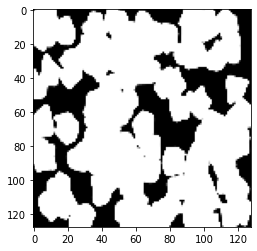

In [25]:
# Display the predictions for a single test image
test_img = test_preds[5, :, :, 0]

plt.imshow(test_img, cmap='gray');

In [26]:
#Threshold the predictions to produce a binary mask
preds_test_thresh = (test_preds >= 0.5).astype(np.uint8)

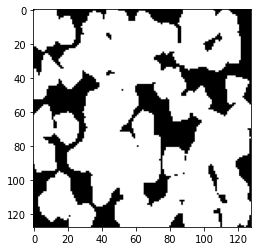

In [27]:
#Display a thresholdeded mask, where white = cell and black = background
test_img = preds_test_thresh[5, :, :, 0]

plt.imshow(test_img, cmap='gray');

## Inspect the results compared to the true mask

Here we will display a test image, its true mask, and the mask that the model predicted for the image.

(-0.5, 127.5, 127.5, -0.5)

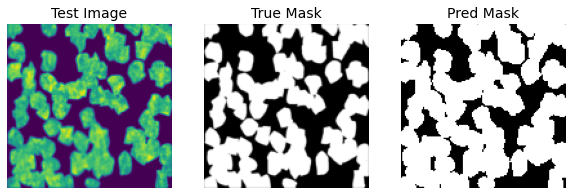

In [28]:
# set up the canvas for the subplots
plt.figure(figsize=(10,10))
plt.axis('Off')

# Our subplot will contain 1 row and 3 columns
# plt.subplot(nrows, ncols, plot_number)

# image
plt.subplot(1,3,1)
test_image = X_test[1, :, :, 0]
plt.imshow(test_image)
plt.title('Test Image', fontsize=14)
plt.axis('off')

# true mask
plt.subplot(1,3,2)
mask_id = df_test.loc[1,'mask_id']
path_mask = 'bbbc005_v1_ground_truth/BBBC005_v1_ground_truth/' + mask_id
mask = imread(path_mask)
mask = resize(mask, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
plt.imshow(mask, cmap='gray')
plt.title('True Mask', fontsize=14)
plt.axis('off')

# predicted mask
plt.subplot(1,3,3)
test_mask = preds_test_thresh[1, :, :, 0]
plt.imshow(test_mask, cmap='gray')
plt.title('Pred Mask', fontsize=14)
plt.axis('off')

In general, the cells are identified well by the segmentation model. However, the cell sizes in the predicted mask appear to exceed the true values. This may be due to the blurring applied to some images. Using a different loss function, adjusting the architecture, or tuning parameters could help improve the performance of the model.